# Preamble

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
%cd drive/My Drive/Recurrent Registration/

/content/drive/My Drive/Recurrent Registration


## pystrum

In [3]:
%cd ./source_code/

/content/drive/My Drive/Recurrent Registration/source_code


In [4]:
# !git clone https://github.com/adalca/pystrum

In [5]:
!pip install ./pystrum

Processing ./pystrum
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for pystrum: filename=pystrum-0.2-py3-none-any.whl size=19535 sha256=2466ce7761a894682640ad020e2c5a5b7e8cd5455c88679ed3089e062d2fb9e4
  Stored in directory: /tmp/pip-ephem-wheel-cache-zj3aet_1/wheels/f2/47/4f/fb3d388f28b1a390edf469fe34793c0ee87cf94f2d392936bc
Successfully built pystrum


In [6]:
%cd ..

/content/drive/My Drive/Recurrent Registration


## neurite

In [7]:
%cd ./source_code/

/content/drive/My Drive/Recurrent Registration/source_code


In [8]:
# !git clone https://github.com/adalca/neurite

In [9]:
!pip install ./neurite

Processing ./neurite
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for neurite: filename=neurite-0.1-py3-none-any.whl size=106722 sha256=f5a78dfecbfdeb5f644b02b87cf6fb9794209ba0713d819648185311882b516e
  Stored in directory: /tmp/pip-ephem-wheel-cache-6lb2mjlv/wheels/cd/4b/1a/0f94eb3a4865b282a7fd0a05ffb0f4041ec22ab6980dc3a007
Successfully built neurite


In [10]:
%cd ..

/content/drive/My Drive/Recurrent Registration


## imports

In [11]:
import pickle
import matplotlib.pyplot as plt
import torch
import numpy as np
import time

import neurite as ne
from source_code.reg_rnn import REG_RNN
from source_code import losses

# Data

## load

In [12]:
with open('./data/images', 'rb') as f:
    images = pickle.load(f)

with open('./data/labels', 'rb') as f:
    labels = pickle.load(f)

## normalize

In [13]:
for i, img in enumerate(images):
    images[i] = (img/img.max()).float()

for i, lb in enumerate(labels):
    labels[i] = (lb/lb.max()).float()

In [14]:
for i, imgs in enumerate(images):
    print(i, "-->", imgs.max(), labels[i].max())

0 --> tensor(1.) tensor(1.)
1 --> tensor(1.) tensor(1.)
2 --> tensor(1.) tensor(1.)
3 --> tensor(1.) tensor(1.)
4 --> tensor(1.) tensor(1.)
5 --> tensor(1.) tensor(1.)
6 --> tensor(1.) tensor(1.)
7 --> tensor(1.) tensor(1.)
8 --> tensor(1.) tensor(1.)
9 --> tensor(1.) tensor(1.)
10 --> tensor(1.) tensor(1.)
11 --> tensor(1.) tensor(1.)
12 --> tensor(1.) tensor(1.)
13 --> tensor(1.) tensor(1.)
14 --> tensor(1.) tensor(1.)
15 --> tensor(1.) tensor(1.)
16 --> tensor(1.) tensor(1.)
17 --> tensor(1.) tensor(1.)
18 --> tensor(1.) tensor(1.)
19 --> tensor(1.) tensor(1.)


## visualize

In [15]:
for i, imgs in enumerate(images):
    print(i, "-->", imgs.shape, labels[i].shape)
print()

0 --> torch.Size([40, 256, 256]) torch.Size([40, 256, 256])
1 --> torch.Size([40, 256, 256]) torch.Size([40, 256, 256])
2 --> torch.Size([40, 256, 256]) torch.Size([40, 256, 256])
3 --> torch.Size([40, 256, 256]) torch.Size([40, 256, 256])
4 --> torch.Size([40, 256, 256]) torch.Size([40, 256, 256])
5 --> torch.Size([40, 256, 256]) torch.Size([40, 256, 256])
6 --> torch.Size([40, 256, 256]) torch.Size([40, 256, 256])
7 --> torch.Size([40, 256, 256]) torch.Size([40, 256, 256])
8 --> torch.Size([40, 256, 256]) torch.Size([40, 256, 256])
9 --> torch.Size([40, 256, 256]) torch.Size([40, 256, 256])
10 --> torch.Size([40, 256, 256]) torch.Size([40, 256, 256])
11 --> torch.Size([40, 256, 256]) torch.Size([40, 256, 256])
12 --> torch.Size([40, 256, 256]) torch.Size([40, 256, 256])
13 --> torch.Size([40, 256, 256]) torch.Size([40, 256, 256])
14 --> torch.Size([40, 256, 256]) torch.Size([40, 256, 256])
15 --> torch.Size([40, 256, 256]) torch.Size([40, 256, 256])
16 --> torch.Size([40, 256, 256]) 

Text(0.5, 1.0, 'label')

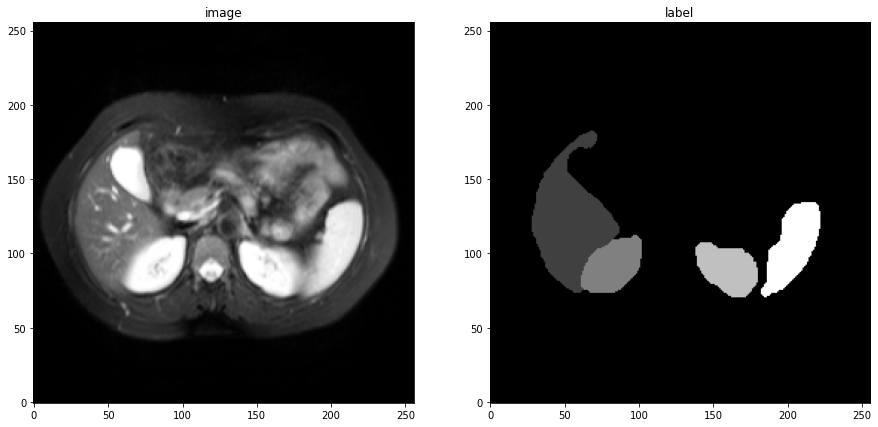

In [16]:
patient_number = 19
fig , (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
ax1.imshow(images[patient_number][15], origin='lower', cmap='gray')
ax2.imshow(labels[patient_number][15], origin='lower', cmap='gray')
ax1.set_title("image")
ax2.set_title("label")

## dataloader

In [17]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


class Dataset_(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
        self.image_size = images[0].shape[1:]
        self.ndims = len(self.image_size)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        outputs = [self.images[index], self.labels[index]]
        return tuple(outputs)


def get_dataloader(images, labels, batch_size, shuffle=False, pin_memory=False, workers=0):
    dataset = Dataset_(images, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, pin_memory=pin_memory,num_workers=workers)
    
    return dataloader

# Args

In [59]:
class Args():
    def __init__(self):        
        self.lr = 0.001
        self.epochs = 20
        self.batch_size = 1
        self.smooth_weight = 0.01 
        self.seg_weight = 0
        self.loss = 'mse' 
        self.int_downsize = 0
        
args = Args()

# Run

## dataloader

In [60]:
dataloader = get_dataloader(images, labels, args.batch_size)

## model

In [61]:
model = REG_RNN(dataloader.dataset.image_size)
model.to('cuda')
_ = model.train()

## optimizer

In [62]:
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

## loss

In [63]:
if args.loss == 'ncc':
    sim_loss_func = losses.NCC().loss
elif args.loss == 'mse':
    sim_loss_func = losses.MSE().loss
else:
    raise ValueError('Image loss should be "mse" or "ncc", but found "%s"' % args.image_loss)

smooth_loss_func = losses.Grad('l2', loss_mult=args.int_downsize).loss
smooth_weight = args.smooth_weight

seg_loss_func = losses.MSE().loss
seg_weight = args.seg_weight

## train

In [64]:
loss_history = []
zero_phi = torch.zeros(39, 2, 256, 256).float().to('cuda')

for epoch in range(args.epochs):

    epoch_loss = 0
    epoch_loss_sim = 0 
    epoch_loss_smooth = 0
    epoch_loss_seg = 0
    total_data_count = 0
    epoch_start_time = time.time()

    for data in dataloader:
        imgs, lbs = data
        bs = imgs.shape[0]

        # shape of imgs/lbs: (bs, seq_size, W, H) --> (seq_size, bs, 1, W, H)
        imgs = imgs.permute(1, 0, 2, 3).unsqueeze(2).to('cuda')
        lbs = lbs.permute(1, 0, 2, 3).unsqueeze(2).to('cuda')

        # shape of moved_imgs/moved_labes: (seq_size - 1, bs, 1, W, H)
        # shape of flows: (seq_size - 1, bs, 2, W, H)
        moved_imgs, moved_lbs, flows = model(imgs, lbs)
        
        # calculate loss
        loss = 0
        for i in range(bs):
            sim_loss = sim_loss_func(imgs[1:, i], moved_imgs[:, i])
            smooth_loss = smooth_loss_func(zero_phi, flows[:, i])
            seg_loss = seg_loss_func(lbs[1:, i], moved_lbs[:, i])
            loss = sim_loss + (smooth_weight * smooth_loss) + (seg_weight * seg_loss)

        # backpropagate and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # update epoch loss
        epoch_loss += loss * bs
        epoch_loss_sim += sim_loss * bs
        epoch_loss_smooth += smooth_loss * bs
        epoch_loss_seg += seg_loss * bs
        total_data_count += bs 
    
    # print epoch info
    loss_history.append(epoch_loss / total_data_count)
    msg = 'epoch %d/%d, ' % (epoch + 1, args.epochs)
    msg += 'loss= %.4e, ' % (epoch_loss / total_data_count)
    msg += 'sim_loss= %.4e, ' % (epoch_loss_sim / total_data_count)
    msg += 'smooth_loss= %.4e, ' % (epoch_loss_smooth / total_data_count)
    msg += 'seg_loss= %.4e, ' % (epoch_loss_seg / total_data_count)
    msg += 'time= %.4f, ' % (time.time() - epoch_start_time)
    print(msg, flush=True)
    

yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
epoch 1/20, loss= 5.0778e-03, sim_loss= 5.0778e-03, smooth_loss= 0.0000e+00, seg_loss= 4.5029e-03, time= 22.1761, 
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
epoch 2/20, loss= 5.0392e-03, sim_loss= 5.0392e-03, smooth_loss= 0.0000e+00, seg_loss= 4.4328e-03, time= 22.0829, 
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
epoch 3/20, loss= 4.9084e-03, sim_loss= 4.9084e-03, smooth_loss= 0.0000e+00, seg_loss= 4.3656e-03, time= 21.9923, 
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
epoch 4/20, loss= 4.1466e-03, sim_loss= 4.1466e-03, smooth_loss= 0.0000e+00, seg_loss= 3.8399e-03, time= 22.0078, 
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
epoch 5/20, loss= 3.3768e-03, sim_loss= 3.3768e-03, smooth_loss= 0.0000e+00, seg_loss= 3.3326e-03, time= 22.0497, 
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
epoch 6/20, loss= 2.8557e-03, sim_loss= 2.8557e-03, smooth_loss= 

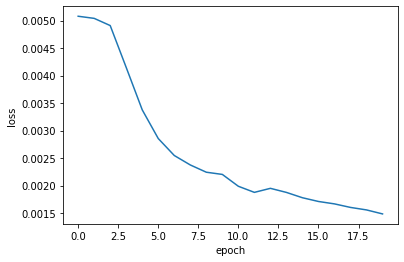

In [71]:
plt.plot(loss_history)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

## evaluate

In [72]:
model.eval();

dice_loss_func = losses.Dice().loss

In [73]:
dice_score = []
for data in dataloader:
        imgs, lbs = data
        bs = imgs.shape[0]

        # shape of imgs/lbs: (bs, seq_size, W, H) --> (seq_size, bs, 1, W, H)
        imgs = imgs.permute(1, 0, 2, 3).unsqueeze(2).to('cuda')
        lbs = lbs.permute(1, 0, 2, 3).unsqueeze(2).to('cuda')

        # shape of moved_imgs/moved_labes: (seq_size - 1, bs, 1, W, H)
        # shape of flows: (seq_size - 1, bs, 2, W, H)
        with torch.no_grad():
            moved_imgs, moved_lbs, flows = model(imgs, lbs)
        
        for i in range(bs):
            zero = torch.zeros_like(lbs[1:, i]).to('cuda')
            one = torch.ones_like(lbs[1:, i]).to('cuda')
            fixed_lbs_ = torch.where(lbs[1:, i] > 0, one, zero)
            moved_lbs_ = torch.where(moved_lbs[:, i] > 0, one, zero)

            # exclude padding
            labeled = []
            for k in range(fixed_lbs_.shape[0]):
                if fixed_lbs_[k].max() != 0.0 and moved_lbs_[k].max() != 0.0:
                    labeled.append(k)
            fixed_lbs_ = fixed_lbs_[labeled]
            moved_lbs_ = moved_lbs_[labeled]          

            dice_score.append((-dice_loss_func(fixed_lbs_, moved_lbs_)).detach().cpu().numpy())

print('mean:', np.mean(dice_score), ', std:', np.std(dice_score))

yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
mean: 0.8938136 , std: 0.020211559


## visualize

In [74]:
def visualize(dataloader, patient_num, slice_ids=[], model=None):

    for i, data in enumerate(dataloader):
        if i != patient_num:
            continue
        
        imgs, lbs = data
        bs = imgs.shape[0]

        # shape of imgs/lbs: (bs, seq_size, W, H) --> (seq_size, bs, 1, W, H)
        imgs = imgs.permute(1, 0, 2, 3).unsqueeze(2).to('cuda')
        lbs = lbs.permute(1, 0, 2, 3).unsqueeze(2).to('cuda')

        if model is not None:
            model.eval();
            with torch.no_grad():
                # shape of moved_imgs/moved_labes: (seq_size - 1, bs, 1, W, H)
                # shape of flows: (seq_size - 1, bs, 2, W, H)
                moved_imgs, moved_lbs, flows = model(imgs, lbs)
                moved_imgs = moved_imgs.detach().cpu().numpy()
                moved_lbs = moved_lbs.detach().cpu().numpy()
                flows = flows.detach().cpu().numpy()

        imgs = imgs.detach().cpu().numpy()
        lbs = lbs.detach().cpu().numpy()

        # images
        moving_imgs = imgs[:-1, 0, 0]
        fixed_imgs = imgs[1:, 0, 0]
        moved_imgs = moving_imgs if model is None else moved_imgs[:, 0, 0]

        # labels
        moving_lbs = lbs[:-1, 0, 0]
        fixed_lbs = lbs[1:, 0, 0]
        moved_lbs = moving_lbs if model is None else moved_lbs[:, 0, 0]

        flows = torch.zeros((39, 256, 256)).numpy() if model is None else flows[:, 0, 0]

        # visualize
        for k in slice_ids:            
            # images 
            pics = [pic[k] for pic in [moving_imgs, fixed_imgs, moved_imgs, flows]] 
            titles = ['moving_img', 'fixed_img', 'moved_img', 'flow']
            ne.plot.slices(pics, titles=titles, cmaps=['gray'], do_colorbars=True, imshow_args=[{'origin':'lower'}]);
            # labels 
            pics = [pic[k] for pic in [moving_lbs, fixed_lbs, moved_lbs, flows]] 
            titles = ['moving_lb', 'fixed_lb', 'moved_lb', 'flow']
            ne.plot.slices(pics, titles=titles, cmaps=['gray'], do_colorbars=True, imshow_args=[{'origin':'lower'}]);
            
            fixed_lb = torch.tensor(fixed_lbs[k]).unsqueeze(0).unsqueeze(0)
            moved_lb = torch.tensor(moved_lbs[k]).unsqueeze(0).unsqueeze(0)
            one = torch.ones_like(fixed_lb)
            zero = torch.zeros_like(fixed_lb)
            fixed_lb = torch.where(fixed_lb > 0, one, zero)
            moved_lb = torch.where(moved_lb > 0, one, zero)

            print('dice_score:', -dice_loss_func(fixed_lb, moved_lb).detach().cpu().numpy())

        break

yo


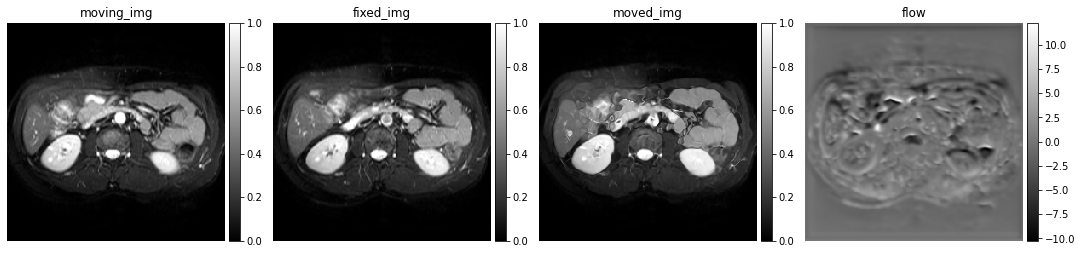

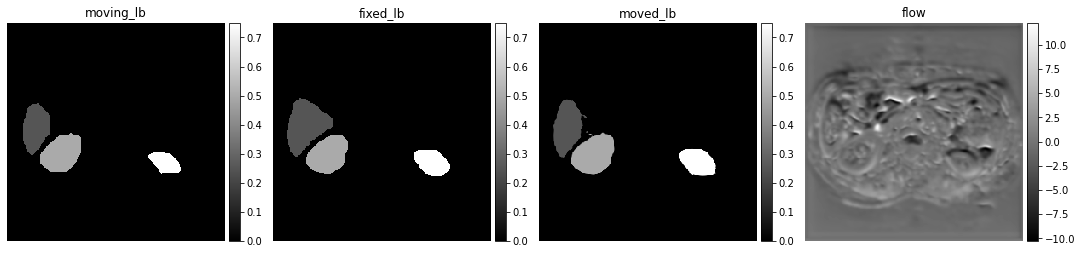

dice_score: 0.90725553


In [76]:
score = visualize(dataloader, patient_num=0, slice_ids=[15], model=model)              